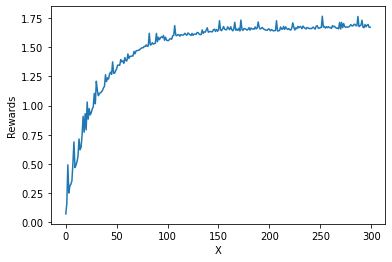

('a2', 'a3', 'a3', 'a2')
('a2', 'a3', 'a3', 'a2')
('a3', 'a3', 'a1', 'a3')
('a3', 'a1', 'a2', 'a3')
('a3', 'a3', 'a1', 'a1')
('a3', 'a2', 'a2', 'a3')
('a1', 'a3', 'a3', 'a2')
('a3', 'a2', 'a2', 'a2')
('a2', 'a1', 'a2', 'a2')
('a1', 'a2', 'a3', 'a2')
('a1', 'a2', 'a2', 'a2')
('a1', 'a2', 'a2', 'a2')
('a1', 'a2', 'a2', 'a2')
('a2', 'a3', 'a3', 'a1')
('a2', 'a1', 'a2', 'a2')
('a2', 'a1', 'a2', 'a2')
('a2', 'a3', 'a2', 'a3')
('a2', 'a3', 'a2', 'a3')
('a1', 'a2', 'a2', 'a1')
('a1', 'a2', 'a2', 'a1')


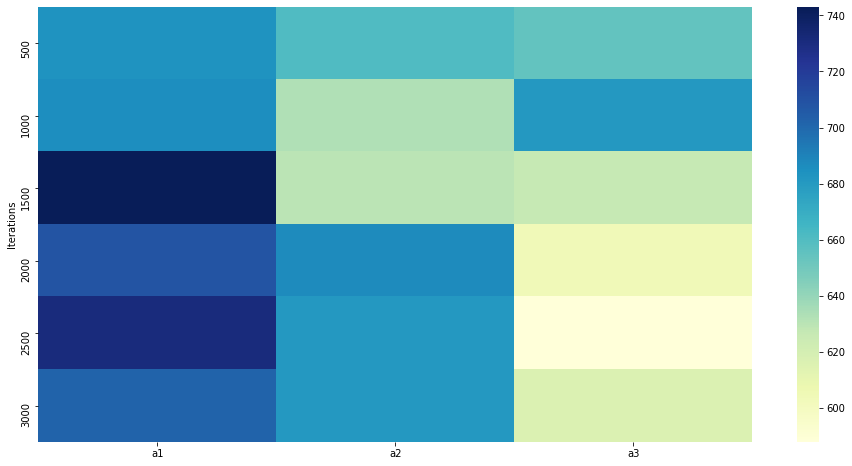

In [10]:
 
# Read data
import pandas as pd
filepath = '/content/Normalized_data_2.csv'  #change according to your filepath
principal_Df = pd.read_csv(filepath,index_col=None)
# Change file name to category
# principal_Df.drop('Unnamed: 0', inplace=True, axis=1)
 
# Utility function to create arrangements. Will work till 3 actions and n grid action^box
from itertools import  permutations
 
def get_combinations(a, box):
  b = [a[0]] *box
  comb = []
 
  for i in range(1, len(a)+1):
    for j in range(len(b)):
      b[j] = a[i%len(a)]
      comb.append(tuple(b))
 
  for c in comb:
    c = list(c)
    if c.count(a[0]) > 1 and c.count(a[0]) < len(c):
      for i in range(c.count(a[0])-1):
        for j in range(len(c)):
          if c[j] == a[0]:
            c[j] = a[len(a)-1]
            comb.append(tuple(c))
            break
    
  comb = [list(c) for c in comb]
  return comb
 
def do_permutation(comb):
  arrangements = []
  for c in comb:
    p = permutations(c) 
    for j in set(list(p)): 
        arrangements.append(j)
  return set(arrangements)
 
# Commented out IPython magic to ensure Python compatibility.
# Imports
#---------------------------------------------------------------------------------------------------------------------#
 
import time
# %matplotlib inline
import numpy as np
from scipy.spatial import distance
import operator
import pickle
import matplotlib.pyplot as plt
import random
#---------------------------------------------------------------------------------------------------------------------#
# Global and helping variables
state_store=[]
BOARD_ROWS = 2
BOARD_COLS = 2
REWARDS = []
#---------------------------------------------------------------------------------------------------------------------#
# Create arragements
actions = ['a1','a2','a3']
comb = get_combinations(actions, BOARD_ROWS*BOARD_COLS )
arrangements = do_permutation(comb)
 
# Drop same action arrangements to maintain diversity
arrangements = list(arrangements)
#arrangements.remove( ('a1', 'a1', 'a1', 'a1') )
#arrangements.remove( ('a2', 'a2', 'a2', 'a2') )
#arrangements.remove( ('a3', 'a3', 'a3', 'a3') )
 
# Select Blues, Pop, Disco
temporary_df = principal_Df[ (principal_Df['Genre']=='blues') | (principal_Df['Genre']=='classical') | (principal_Df['Genre']=='country')  ]
pd.set_option('display.max_rows', temporary_df.shape[0]+1)
temporary_df = temporary_df.reset_index(drop = True)
 
# Get the mean of each genres
mean_blues = tuple(principal_Df[principal_Df['Genre']=='blues'].describe().loc['mean'])
mean_disco = tuple(principal_Df[principal_Df['Genre']=='classical'].describe().loc['mean'])
mean_pop = tuple(principal_Df[principal_Df['Genre']=='country'].describe().loc['mean'])
 
def changeSigFigto3(d):
  """
  Utility function to change float to 3 signifant figutes after decimal place
  """
  temp = []
  for value in d:
    temp.append(round(value,3))
  return tuple(temp)
 
 
# User Grid Input
PrimaryUser=[]
SecondaryUser =[]
PrimaryUser.append(changeSigFigto3(mean_blues))
SecondaryUser.append(changeSigFigto3(mean_disco))
SecondaryUser.append(changeSigFigto3(mean_pop))
 
def changeActiontoRow(action):
  """
  Utility function to map local actions to select random rows from respective genres
  a2r : range of data rows of a genre
  """
  a2r = {
    'a1':(0,999),
    'a2':(1000,1900),
    'a3':(2000,2800)
  }
  return changeSigFigto3(tuple(temporary_df.loc[random.randint(a2r[action][0], a2r[action][1])][1:]))
 
# Create board to store reward
REWARD_BOARD =  np.zeros( (len(arrangements), len(arrangements)),dtype='object')
 
states = arrangements.copy()
action_space = arrangements.copy()
# Converting to dictionary mappers
state_dict = {}
for i in range(len(states)):
  # key = 'S_'+ str(i)
  state_dict[i] = states[i]
action_dict = {}
for i in range(len(action_space)):
  # key = 'A_'+ str(i)
  action_dict[i] = action_space[i]
 
def createBoardForState(location):
  """
  Agent creates local boards and populates values by local action
  """
  index = 0
  board =  np.zeros( (BOARD_ROWS, BOARD_COLS),dtype='object')
  for row in range(BOARD_ROWS):
    for col in range(BOARD_COLS):
      board[row][col] = changeActiontoRow(location[index])
      index+=1
  return board
import math as math
def calculcateReward(board,user):
  """
  Agent calculates reward using euclidean distance between randomly selected k values from local boards
  """
  output_reward =0
 
  k = 2
  for i in range(k):
    # print([random.sample(range(int((BOARD_COLS))), 1)[0]],[random.sample(range(int((BOARD_ROWS))), 1)[0]])
    pos=board[random.sample(range(int((BOARD_COLS))), 1)[0]][random.sample(range(int((BOARD_ROWS))), 1)[0]] 
    euc_dist = distance.euclidean(pos, user)
    if euc_dist == 0:
      dst = 0
    else:
      dst = 1.0/euc_dist
      dst=math.log10(abs(dst))
    output_reward =dst+output_reward
  return output_reward
 
# Set state reward values.
test_state_values = {}
for i in range(len(arrangements)):
  test_state_values[i] = 0  # set initial value to 0 1x78 [0] ->    -[MDP value]<-  [R]
 
# Randomly start off with a state
def playARound():  #78*78 *0.3 *3000
  state_action = []
  # Exploration rate
  exp_rate = 0.3
  mx_nxt_reward = 0
  action = 0
  #  Epsilon - Greedy Method
  for i in range(len(arrangements)):
    if np.random.uniform(0, 1) <= exp_rate:
      # Select random action
      action = np.random.choice(list(action_dict.keys()))
    else:
      # greedy action
      for a in action_dict:
          # Check 
          nxt_reward = test_state_values[a]#
          if nxt_reward >= mx_nxt_reward:
              action = a
              mx_nxt_reward = nxt_reward
    state_action.append(action)
  return state_action
 
noOfRounds = 3000
mdp_reward =[]
mdp_vals = []
for i in range(noOfRounds):
  state_action = playARound()
  #print("Round:", i)
  #print("End of state of this round: ", action_dict[state_action[-1]])
  lr = 0.2
  reward = calculcateReward(createBoardForState(action_dict[state_action[-1]]),PrimaryUser[0])
  for s in reversed(state_action):
    reward = test_state_values[s] + lr * (reward - test_state_values[s])
    test_state_values[s] = round(reward, 3)
  max_key = max(test_state_values, key=test_state_values.get)
  #print("MDP Value: ",max_key)
  mdp_vals.append(max_key)
  #print("Best action to take for this round: ", action_dict[max_key])
  mdp_reward.append(test_state_values[max_key])
  #print("----------------")
 
len(mdp_reward)
 
def checkRewardGraph(current_reward):
    # Visualize Reward Trend over iterations.
    x=[]
    gapped_reward = []
    # Reward after 10 iterations
    for i in range(len(current_reward)):
      if i%10 == 0:
        gapped_reward.append(current_reward[i])
    
    for j in range(len(gapped_reward)):
      x.append(j)
 
    # import pandas library
    import pandas as pd 
    # dictionary with list object in values
    details = {
        'Rewards' : gapped_reward,
        'X' : x
    }
    # creating a Dataframe object 
    df = pd.DataFrame(details)
    import seaborn as sns
    import matplotlib.pyplot as plt
 
    # Construct iris plot
    sns.lineplot(x="X", y="Rewards", data=df)
 
    # Show plot
    plt.show()
checkRewardGraph(mdp_reward)
 
#Check action of last 50 key vals of MDP
mdp_c = mdp_vals.copy()
index = 0
for keys in reversed(mdp_c):
  #print('Round: ',index+1)
  if index == 20:
    break
  print(action_dict[keys])
  index+=1
 
# Check action vs iteration graph
def checkActionGraph(current_action):
    # Visualize Reward Trend over iterations.
    x=[]
    gapped_reward = []
    # Reward after 10 iterations
    for i in range(len(current_action)):
      if (i+1)%20 == 0:
        gapped_reward.append(current_action[i])
    
    for j in range(len(gapped_reward)):
      x.append(j)
 
    # import pandas library
    import pandas as pd 
    # dictionary with list object in values
    details = {
        'Rewards' : gapped_reward,
        'X' : x
    }
    # creating a Dataframe object 
    df = pd.DataFrame(details)
    import seaborn as sns
    import matplotlib.pyplot as plt
 
    # Construct iris plot
    sns.lineplot(x="X", y="Rewards", data=df)
 
    # Show plot
    plt.show()
#checkActionGraph(mdp_vals)
 
# Prepare heatmap
a1_count=0
a2_count=0
a3_count=0
collective_action=[]
a1=[]
a2=[]
a3=[]
iterations = []
index =1
for vals in mdp_vals:
 
  collective_action.append(vals)
  # For every 20 iterations, collectively count number of a1 a2 a3
  if index%500==0:
    
    #print(index)
    iterations.append(index)
    for a in collective_action:
      a1_count+=action_dict[a].count('a1')
      a2_count+=action_dict[a].count('a2')
      a3_count+=action_dict[a].count('a3')
    a1.append(a1_count)
    a2.append(a2_count)
    a3.append(a3_count)
    
    a1_count=0
    a2_count=0
    a3_count=0
    collective_action=[]
 
  index+=1
df = pd.DataFrame({'Iterations':iterations, 'a1':a1, 'a2':a2, 'a3':a3 })
df.set_index('Iterations',inplace=True)
 
import seaborn as sns
fig_dims = (16, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(data = df,ax=ax,cmap="YlGnBu")

In [ ]:
a = np.asarray(df)
np.savetxt("mpdr.csv", a, delimiter=",")

In [5]:
df

,a1,a2,a3
Iterations,,,
500,679,646,675
1000,710,663,627
1500,697,661,642
2000,694,687,619
2500,687,676,637
3000,718,648,634


In [ ]:
 
from itertools import  permutations
 
def get_combinations(a, box):
  b = [a[0]] *box
  comb = []
 
  for i in range(1, len(a)+1):
    for j in range(len(b)):
      b[j] = a[i%len(a)]
      comb.append(tuple(b))
 
  for c in comb:
    c = list(c)
    if c.count(a[0]) > 1 and c.count(a[0]) < len(c):
      for i in range(c.count(a[0])-1):
        for j in range(len(c)):
          if c[j] == a[0]:
            c[j] = a[len(a)-1]
            comb.append(tuple(c))
            break
    
  comb = [list(c) for c in comb]
  return comb
 
def do_permutation(comb):
  arrangements = []
  for c in comb:
    p = permutations(c) 
    for j in set(list(p)): 
        arrangements.append(j)
  return set(arrangements)
 
 
def perm_rep(A,i,bsize,cur, arrangements):
  if i == bsize:
    #print(cur)
    arrangements.append(list(cur))
    return 
  
  for j in range(len(A)):
    cur.append(A[j])
    perm_rep(A,i+1,bsize,cur,arrangements)
    cur.pop()
  
 
BOARD_ROWS = 3
BOARD_COLS = 3
REWARDS = []
arrangements = []
#---------------------------------------------------------------------------------------------------------------------#
# Create arragements
actions = ['a1','a2','a3']
perm_rep(actions, 0, BOARD_ROWS*BOARD_COLS,  [], arrangements)
#comb = get_combinations(actions, BOARD_ROWS*BOARD_COLS )
#print(len(comb)) 
#arrangements = do_permutation(comb)
print(len(arrangements))

19683


In [ ]:
arrangements

{('a1', 'a1', 'a1', 'a1'),
 ('a1', 'a1', 'a1', 'a2'),
 ('a1', 'a1', 'a1', 'a3'),
 ('a1', 'a1', 'a2', 'a1'),
 ('a1', 'a1', 'a2', 'a2'),
 ('a1', 'a1', 'a2', 'a3'),
 ('a1', 'a1', 'a3', 'a1'),
 ('a1', 'a1', 'a3', 'a2'),
 ('a1', 'a1', 'a3', 'a3'),
 ('a1', 'a2', 'a1', 'a1'),
 ('a1', 'a2', 'a1', 'a2'),
 ('a1', 'a2', 'a1', 'a3'),
 ('a1', 'a2', 'a2', 'a1'),
 ('a1', 'a2', 'a2', 'a2'),
 ('a1', 'a2', 'a2', 'a3'),
 ('a1', 'a2', 'a3', 'a1'),
 ('a1', 'a2', 'a3', 'a2'),
 ('a1', 'a2', 'a3', 'a3'),
 ('a1', 'a3', 'a1', 'a1'),
 ('a1', 'a3', 'a1', 'a2'),
 ('a1', 'a3', 'a1', 'a3'),
 ('a1', 'a3', 'a2', 'a1'),
 ('a1', 'a3', 'a2', 'a2'),
 ('a1', 'a3', 'a2', 'a3'),
 ('a1', 'a3', 'a3', 'a1'),
 ('a1', 'a3', 'a3', 'a2'),
 ('a1', 'a3', 'a3', 'a3'),
 ('a2', 'a1', 'a1', 'a1'),
 ('a2', 'a1', 'a1', 'a2'),
 ('a2', 'a1', 'a1', 'a3'),
 ('a2', 'a1', 'a2', 'a1'),
 ('a2', 'a1', 'a2', 'a2'),
 ('a2', 'a1', 'a2', 'a3'),
 ('a2', 'a1', 'a3', 'a1'),
 ('a2', 'a1', 'a3', 'a2'),
 ('a2', 'a1', 'a3', 'a3'),
 ('a2', 'a2', 'a1', 'a1'),
 